In this post I'll show how we can train an ensemble of neural network classifiers cooperateively in a largely decoupled way, such that we can distribute the training of the ensemble over a potentially very large cluster with low communication overhead.

The gist is to mix manual and automatic differentiation, as I [described in a previous post](http://www.awebb.info/blog/who_needs), such that our framework can operate independently on each node without requiring any knowledge of the larger model/computational cluster.  I made use of this trick in some [recent work](https://arxiv.org/abs/1902.04422) on the LAMBDA project (EPSRC reference EP/N035127/1) at the University of Manchester.

By training an ensemble cooperatively, I mean that we'll tune the parameters of the networks by minimizing the cross entropy between the ensemble predictions and the target, rather than training each network individually by minimizing the cross entropy between that network's predictions and the target. This is an idea that's gaining some traction. See for example:

- Joint Training of Neural Network Ensembles, Webb, Reynolds et al. ([arxiv.org/abs/1902.04422](https://arxiv.org/abs/1902.04422))
- Coupled Ensembles of Neural Networks, Dutt, Pellerin, Quénot ([arxiv.org/abs/1709.06053](https://arxiv.org/abs/1709.06053))
- Born Again Neural Networks, Furlanello, Lipton et al. ([arxiv.org/abs/1805.04770](https://arxiv.org/abs/1805.04770))

It might be more natural to think of the ensemble as being a single network with a modular structure, since the individual members of the ensemble are not encouraged to individually fit the data at all. The following figure shows the structure of the ensemble/modular network.

<img src="./img/net_schematic.png" width="250" />

Suppose we have $M$ neural networks indexed by $j$ which, for input ${\bf{x}}$, have a a vector of logits $f^{(j)}({\bf x})$ and of prediction probabilities $q^{(j)}({\bf x}) = \sigma(f^{(j)}({\bf x}))$, where $\sigma$ is the softmax function. We'll use as our ensemble predictions $\bar{q}({\bf x})$ the normalized geometric mean of the individual model predictions, i.e., a Product of Experts:
$$
\bar{q}_k({\bf x}) = \frac{1}{Z} \prod_{j=1}^M q_k^{(j)}({\bf x}) ^{1/M}\quad,
$$
where $Z$ is a normalization term and the index $k$ indicates the $k$th class. Note that the ensemble prediction $\bar{q}({\bf x})$ is equal to the softmax function ${\sigma}$ applied to the arithmetic mean of the individual network logits:
$$
\bar{q}({\bf x}) = \sigma\left(\frac{1}{M} \sum_{j=1}^M f^{(j)}({\bf x}) \right) \quad .
$$

Now I'll show two equivalent methods to train such an ensemble. The first is the usual way, defining a single computational graph. For the second method we'll define a seperate computational graph for each ensemble member, and these can be distributed over computational nodes with minimal communication overhead. A seperate instance of PyTorch will run on each computational node, without any given instance knowing about the whole computational graph/model structure.

Here are the usual imports:

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now let's set up a data loader for the training data from MNIST.

In [2]:
batch_size = 200
learning_rate = 0.5
momentum = 0.9

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

Now let's define the invididual network architectures. Although they could be heterogeneous, here we'll use the same very small convolutional network architecture for each member of the ensemble.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3, stride=2)
        self.fc1 = nn.Linear(40, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 6)
        x = x.view(-1, 40)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Single Computational Graph Method

Below is the more typical, naive way to train our ensemble, by defining it as a single computational graph, defining a loss function, and then doing backpropagation in order to set the network parameters to minimize that loss function.

In [4]:
def train_single_computational_graph(epochs=1,
                                     ensemble_size=1,
                                     seed=None):
    criterion = nn.CrossEntropyLoss()
    if seed is not None:
        torch.manual_seed(seed)

    # Initialize M models
    models = [Net().to(device) for i in range(ensemble_size)]
    # Initialize a single optimizer
    optimizer = optim.SGD(nn.ModuleList(models).parameters(),
                          lr=learning_rate,
                          momentum=momentum)

    losses = []
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            ensemble_logits = torch.mean(
                torch.stack([model.forward(data) for model in models]),
                dim=0)
        
            # Define a loss function for the ensemble to be minimized
            loss = criterion(ensemble_logits, target)
            loss.backward()
            optimizer.step()
        
            losses.append(loss.item())
            
    return losses

## Multiple Computational Graphs Method

An alternative approach is to do the first step of backpropagation manually (as discussed in a [previous post](http://www.awebb.info/blog/who_needs)), and note that
$$
\frac{\partial L}{\partial f_k^{(j)}} = \bar{q}_k - p_k \quad,
$$
where $L$ is the ensemble cross entropy loss and $p$ is a one-hot encoding of the target. We can see from this that all of the interaction between ensemble members during training can be achieved by distributing the ensemble prediction vector $\bar{q}$ to $M$ seperate PyTorch instances, each of which handles a seperate ensemble member, and then manually setting $\frac{\partial L}{\partial f_k^{(j)}}$ in each of them as above. This constitutes an alternative, equivalent training procedure which, in more detail, works as follows.

- Set up a separate computational graph and optimizer for each network in the ensemble, possibly each on a seperate computational node.
- For each iteration:
    - Do a forward pass of each, computing the logits for that network.
    - Take the arithmetic mean of the logits and apply the softmax function to get the ensemble predictions $\bar{q}$. If the ensemble members are on seperate computational nodes, this will require communication of the logits.
    - Do a backward pass of each graph, starting at the logit layer, with the gradient explicitly set to $(\bar{q} - p) / (\text{ensemble_size} * \text{batch_size})$. If the ensemble members are on seperate computational nodes, this will require communication of the ensemble prediction probability vector.
    
This is done in the following code. I've defined a $\texttt{ComputationalNode}$ class to emphasize the fact that each sub-model and optimizer could be run on a separate node in a computational cluster running a separate instance of PyTorch; the PyTorch framework doesn't need to know anything about our wider computational cluster. We need to handle a small amount of communication: each node needs to send its $B\times K$ logits per iteration, where $B$ is the batch size and $K$ is the number of classes, and then needs to receive the $B\times K$ ensemble prediction probabilities.

In [5]:
class ComputationalNode():
    
    # Initialize a model and an optimizer for this node
    def __init__(self, ensemble_size):
        self.model = Net().to(device)
        self.optimizer = optim.SGD(self.model.parameters(),
                                   lr=learning_rate,
                                   momentum=momentum)
        self.ensemble_size = ensemble_size
        
    # Do the forward pass for this node, returning the logits
    def forward_pass(self, data):
        self.optimizer.zero_grad()
        self.logits = self.model.forward(data)
        return self.logits.detach()
    
    # Do a backward pass starting at the logit layer using the ensemble predictions
    def backward_pass(self, target, ensemble_prediction):
        self.logits.backward(1/(batch_size * self.ensemble_size) * (ensemble_prediction - target))
        self.optimizer.step()


# Get a one-hot encoding of the target
def get_one_hot_(target, target_one_hot):
    target_one_hot.zero_()
    target_one_hot.scatter_(1, torch.unsqueeze(target.data, 1), 1)

    
def train_multiple_computational_graphs(epochs=1,
                                        ensemble_size=1,
                                        seed=None):
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=-1)
    target_one_hot = torch.FloatTensor(batch_size, 10).to(device)
    if seed is not None:
        torch.manual_seed(seed)

    # Setup the M computational nodes with a model and optimizer each
    nodes = [ComputationalNode(ensemble_size) for i in range(ensemble_size)]

    losses = []
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            get_one_hot_(target, target_one_hot)
            
            # Do the forward pass for each node
            # Gather the logits
            ensemble_logits = torch.mean(
                torch.stack([node.forward_pass(data) for node in nodes]),
                dim=0)

            # Compute the ensemble prediction
            ensemble_prediction = softmax(ensemble_logits)
            
            # Do the backward pass for each node
            for node in nodes:
                node.backward_pass(target_one_hot, ensemble_prediction)
        
            loss = criterion(ensemble_logits, target)
            losses.append(loss.item())
            
    return losses

Running the two training procedures from the same initial state and plotting the ensemble loss over time, we see that initially it's pretty much exactly the same. After a while, small numerical differences seem to accumulate.

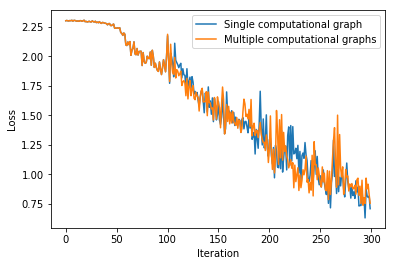

In [6]:
losses_single_graph = train_single_computational_graph(epochs=1,
                                                       ensemble_size=10,
                                                       seed=900)
losses_multiple_graphs = train_multiple_computational_graphs(epochs=1,
                                                             ensemble_size=10,
                                                             seed=900)

xs = np.arange(len(losses_single_graph))
plt.plot(xs, losses_single_graph, label='Single computational graph')
plt.plot(xs, losses_multiple_graphs, label='Multiple computational graphs')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

## Summary

We've seen in this post a way to distribute the joint training of an ensemble over a computational cluster with low communication overheads, and without our deep learning framework having to know about the cluster and manage communication across it.

One obvious optimization to the distributed training procedure described above is to set the nodes up in a tree topology to minimize the total amount of communication in getting the individual network logits up to the aggregation node. Another optimization is to pipeline things, and have each node do the forward pass of the next minibatch while it waits for the ensemble predictions to come back allowing the computation of the backward pass of the previous minibatch, rather than blocking.

What's potentially very nice about this procedure is its simplicity and the small amount of communication required. Although it's comparing apples to oranges, compare to batch parallelism, where you duplicate a single model across the computational nodes and each node computes parameter gradients on a very small minibatch. The parameter gradients are then shared and the mean is taken. The communication requirements for this procedure are that each node must send and receive a gradient for every parameter. For, e.g., a [Wide ResNet 28-12](https://arxiv.org/abs/1605.07146), this requires each node sending and receiving 52.5 million values per iteration. Batch parallelism also restricts our model size to what can fit in memory on a single node.
The procedure described in this post allows us to train modular/ensemble models of unlimited size, with each computational node sending and receiving $B\times K$ values per iteration, where $B$ is the batch size and $K$ is the number of classes. E.g., for a 10 class problem with batch size of 100, we communicate only 1000 values per iteration.